In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df_final1 = pd.read_pickle("Data/df_with_history_>10_orders.pkl")

In [3]:
recipients_new = []

for i in df_final1["recipient"]:
    if i not in recipients_new:
        recipients_new.append(i)
        
print(len(recipients_new))

3600


In [4]:
def scale(X_train, y_train, X_test, y_test, X_val=None, y_val=None):
    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    y_train = scaler.fit_transform(np.asarray(y_train).reshape(-1,1))

    X_test = scaler.fit_transform(X_test)
    y_test = scaler.fit_transform(np.asarray(y_test).reshape(-1,1))

    if X_val != None and y_val != None:
        X_val = scaler.fit_transform(X_val)
        y_val = scaler.fit_transform(np.asarray(y_val).reshape(-1,1))
    
        return X_train, y_train, X_test, y_test, X_val, y_val, scaler
    
    return X_train, y_train, X_test, y_test, scaler

In [5]:
def recipient_modeller(dataframe, recipients, model):
    model_dict = {}
    data_dict = {}
    count = 0
    
    for recipient in recipients:
        test_df = dataframe[dataframe.recipient == recipient]
        
        X = test_df.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                            "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee", "Rundvee",
                            "t_5", "t_4", "t_3", "t_2", "t_1"]]
        
        y = test_df["difference"]
        
        X_train = X[0:-5]
        X_test = X[-5:]
        y_train = y[0:-5]
        y_test = y[-5:]
  
        X_train, y_train, X_test, y_test, scaler = scale(X_train, y_train, X_test, y_test)
        
        model.compile(optimizer="adagrad", 
                      loss='mean_squared_error', 
                      metrics=tf.keras.metrics.RootMeanSquaredError())
        history = model.fit(X_train, y_train, epochs=20, use_multiprocessing=True, verbose=0)
        
        model_dict[f"model_{int(recipient)}"] = [model]
        data_dict[f"model_{int(recipient)}"] = [X_test, y_test, scaler]
        
        count += 1
        if count % 100 == 0:
            print(f"{count} models done.")
        
    return model_dict, data_dict
        

In [6]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(16,), activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation="sigmoid", kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

In [7]:
model_dict, data_dict = recipient_modeller(df_final1, recipients_new, model)

100 models done.
200 models done.
300 models done.
400 models done.
500 models done.
600 models done.
700 models done.
800 models done.
900 models done.
1000 models done.
1100 models done.
1200 models done.
1300 models done.
1400 models done.
1500 models done.
1600 models done.
1700 models done.
1800 models done.
1900 models done.
2000 models done.
2100 models done.
2200 models done.
2300 models done.
2400 models done.
2500 models done.
2600 models done.
2700 models done.
2800 models done.
2900 models done.
3000 models done.
3100 models done.
3200 models done.
3300 models done.
3400 models done.
3500 models done.
3600 models done.


In [9]:
rmse_values = []

for i in model_dict:
    test_pred = model_dict[i][0].predict(data_dict[i][0]).ravel()
    inv_test_pred = data_dict[i][2].inverse_transform(test_pred.reshape(-1, 1))
    inv_y_test = data_dict[i][2].inverse_transform(data_dict[i][1].reshape(-1, 1))

    mse_test = mean_squared_error(inv_y_test, inv_test_pred)
    
    rmse_values.append(np.sqrt(mse_test))

In [10]:
print(f"Mean of the mean RMSE per customer: {np.round(np.mean(rmse_values),2)}.")
print(f"Smallest mean RMSE: {np.round(np.min(rmse_values),2)}.")
print(f"Largest mean RMSE: {np.round(np.max(rmse_values),2)}.")

Mean of the mean RMSE per customer: 11.539999961853027.
Smallest mean RMSE: 0.05000000074505806.
Largest mean RMSE: 520.0399780273438.


In [11]:
print(f"Mean of the mean RMSE per customer, without the 150 largest values: {np.round(np.average(sorted(rmse_values)[0:-150]),2)}.")

Mean of the mean RMSE per customer, without the 150 largest values: 6.989999771118164.


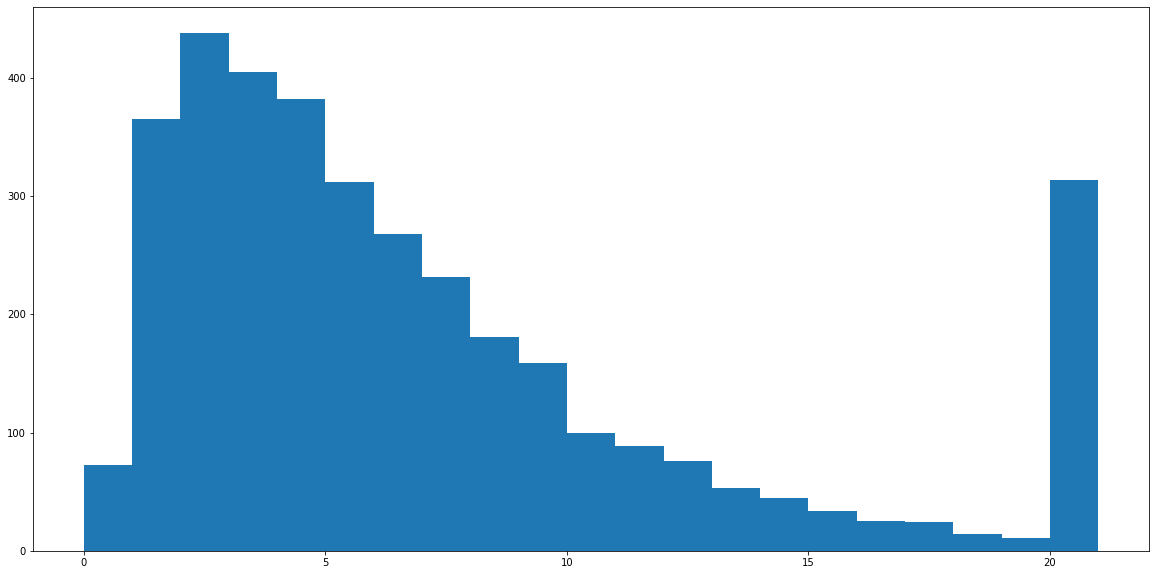

In [12]:
rmse_values_array = np.asarray(rmse_values)

plt.figure(figsize=(20,10))

plt.hist(rmse_values_array.clip(min=0, max=21), range=[0,21], bins=21)
plt.show()

In [13]:
lower = []

for i in rmse_values:
    if i <= 6:
        lower.append(i)

print(len(lower))
print(len(lower)/len(rmse_values))

1975
0.5486111111111112


In [14]:
final_percentages =[]

for i in model_dict:
    inv_test_pred = data_dict[i][2].inverse_transform(test_pred.reshape(-1, 1))
    inv_y_test = data_dict[i][2].inverse_transform(data_dict[i][1].reshape(-1, 1))
    
    percentages = []
    
    for idx, val in enumerate(inv_test_pred):
        perc = np.abs(val-inv_y_test[idx])/inv_y_test[idx]
        percentages.append(perc[0])
        
    final_percentages.append(np.mean(percentages))

In [15]:
print(f"Minimum percent error: {np.round(np.min(final_percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(final_percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(final_percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 25.170000076293945
Mean percent error: 0.6600000262260437


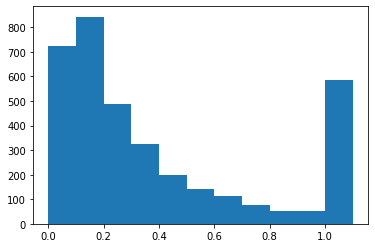

In [16]:
final_percentages = np.asarray(final_percentages)

plt.hist(final_percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [17]:
lower = []

for i in final_percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(final_percentages),2)}")

Number of orders with a percent error lower than 0.5: 2578
Percentage of orders with a percent error lower than 0.5: 0.72


In [18]:
final_differences =[]

for i in model_dict:
    inv_test_pred = data_dict[i][2].inverse_transform(test_pred.reshape(-1, 1))
    inv_y_test = data_dict[i][2].inverse_transform(data_dict[i][1].reshape(-1, 1))
    
    differences = []
    
    for idx, val in enumerate(inv_test_pred):
        diff = np.abs(val[0]-inv_y_test[idx][0])
        differences.append(diff)
        
    final_differences.append(np.mean(differences))

In [19]:
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in final_differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in final_differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in final_differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in final_differences]

In [20]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(final_differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(final_differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.12
Percentage of orders predicted correctly within 3 days: 0.43
Percentage of orders predicted correctly within 5 days: 0.65
Percentage of orders predicted correctly within 7 days: 0.79
